# A04- Ingeniería inversa

Gonzalo Cano Padilla


### Celda 1

En esta celda lo que hacemos es importar el dataset de las caras y cargarlo.

Luego se muestra los nombres de las personas que muestran su cara en el dataset y el tamaño

**Referencia:** fetch_lfw_people?

In [12]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


---

### Celda 2

Importamos la libreria para poder hacer las gráficas

Luego crea una figura y una cuadrícula de ejes de 3 filas y 5 columnas, para poder mostrar todas las caras cargadas

El for lo que hace es un ciclo para mostrar todas las caras en la cuadrícula que ya definimos. En este ciclo lo que se hace es buscar la cara i para luego irla poniendo en la cuadrícula junto con su nombre por debajo.

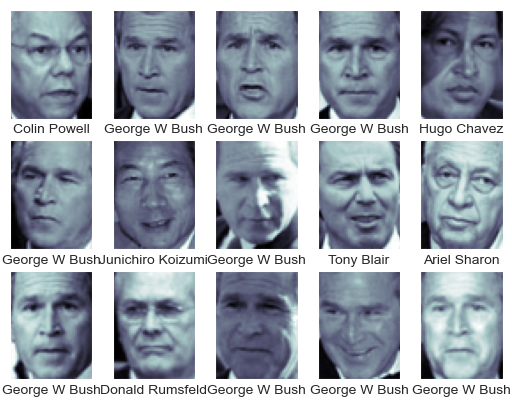

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

plt.show()

---

### Celda 3

Primero se importan las librerias necesarias para maquinas de soporte, pipeline y el PCA

Luego definimos el PCA, configurando una reducción dimensional a 150 componentes principales, el **whiten=True** lo que hace es: transforma los componentes para que todos tengan varianza unitaria (1) y sean no correlacionados.

| “Whitening removes the correlations between features and scales the components to unit variance.”
(Fuente: Scikit-learn PCA docs)

Luego definimos el SVC usando el kernel de rbf que permite fronteras no lineales y suele funcionar bien en datos de alta dimensión tras una reducción con PCA.

Luego hacemos el pipeline, primero se aplica el PCA para luego hacer el SVC


In [14]:

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

---

### Celda 4

Aqui separamos los datos en train y en test

In [15]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

---

### Celda 5

Lo primero que hacemos es definir un diccionario con los parametros y las combinaciones que queremos probar.
* svc__C corresponde al parámetro C del clasificador SVM dentro del pipeline.
* svc__gamma corresponde al parámetro gamma del kernel RBF del SVM.

Luego se hace el GridSearch tomando en cuenta el modelo que ya definimos en el pipeline y los parametros que definimos en el paso anterior. GridSearch lo que hace es aplicar k-folds a los datos, luego calcula el desempeño promedio y luego elige la combinación con el mejor resultado promedio


In [16]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 48s, sys: 1min 30s, total: 3min 18s
Wall time: 18.9 s
{'svc__C': 5, 'svc__gamma': 0.001}


---

### Celda 6

Aqui guardamos el modelo optimo y la predicción del mejor modelo

In [17]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

---

### Celda 7

En esta celda también se muestran todas las caras en una cuadrícula
* Si son iguales -> el modelo acertó -> color negro.
* Si son diferentes -> el modelo falló -> color rojo.

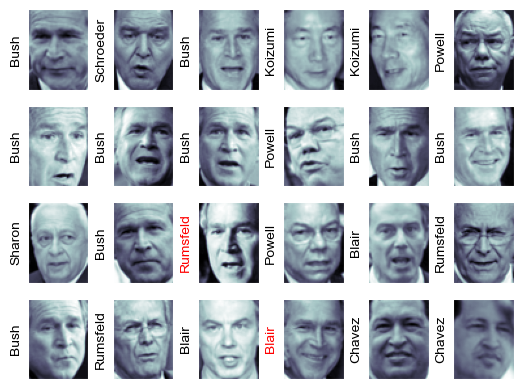

In [22]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
plt.show()

---

### Celda 8

En esta celda lo que hacemos es generar un resumen estadístico del desempeño de un clasificador, nos muestra métricas como precisión, recall, f1_score y support

* Precision -> Proporción de predicciones correctas entre las que el modelo dijo que pertenecían a esa clase.
* Recall -> Proporción de aciertos entre todos los casos reales de esa clase.
* F1-score -> Media armónica de precision y recall. Resume el equilibrio entre ambos.
* Support -> Número real de ejemplos de esa persona en el conjunto de prueba.




In [19]:

from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



---

### Celda 8

Aqui lo que hacemos es un heatmap que nos muestra lo real y lo predicho

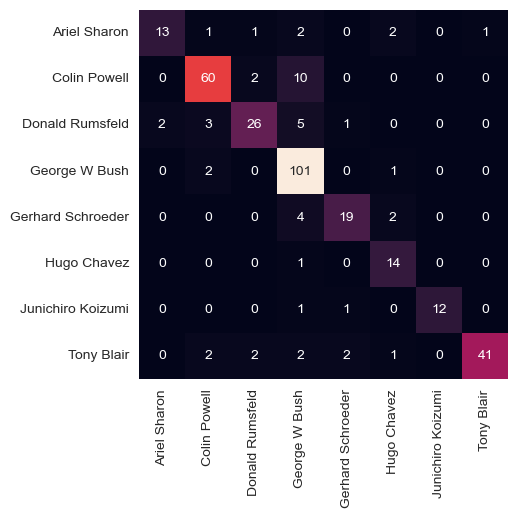

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.show()